<a href="https://colab.research.google.com/github/JeremyAnretar/Business-Use-Cases/blob/main/Trajet_Autoroute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buffle Malin

L'objectif de ce trajet est de réussir à déterminer l'heure de départ idéal pour un trajet par Autoroute de la Lozère à Paris un Samedi 30 Août comportant une pause de 30 minutes toutes les 1h30.

Un voyage idéal est défini par les parties prenantes au projet (Mon amie, mon chien et moi) comme un trajet fluide tout du long ou avec tout au plus quelques ralentissements.

In [ ]:
#On commence par importer les bibliothèques qui nous serviront
import math
import pandas as pd

#On définit les états de traffic possibles
states = ("fluide", "ralenti", "bouche")

#On créé une fonction qui permettra de convertir minutes en heure
def hhmm(minutes_ap_minuit: int) -> str:
  m = minutes_ap_minuit % (24*60)
  h, mm = divmod(m, 60)
  return f"{h:02d}:{mm:02d}"

# Etape 1

Définition des sections. On divise notre Trajet en sections. On va créer un dataframe avec:
* l'id section
* l'ordre (on est obligé de faire le trajet dans un ordre prédéfini, on ne peut pas faire Vierzon - Orléans puis Saint Flour Millau, puis Saint Arnoult - Paris, physiquement ça ne marche pas)
* le nom (id section c'est pour les jointures, le nom c'est pour la lecture et les représentations graph)
* le nombre de km
* un booléen is_idf parce que la limitation est différente

In [ ]:
#Création du dataframe section, basé sur les sections VINCI AUTOROUTES et les distances Google Maps
sections = pd.DataFrame([
{"section_id": "S1", "ordre":1, "nom":"Millau > Saint Flour", "km": 132, "is_idf" : False},
{"section_id": "S2", "ordre":2, "nom":"Saint Flour > Clermont-Ferrand", "km": 108, "is_idf" : False},
{"section_id": "S3", "ordre":3, "nom":"Clermont-Ferrand > Bourges", "km": 189, "is_idf" : False},
{"section_id": "S4", "ordre":4, "nom":"Bourges > Vierzon", "km": 39, "is_idf" : False},
{"section_id": "S5", "ordre":5, "nom":"Vierzon > Orléans", "km": 89, "is_idf" : False},
{"section_id": "S6", "ordre":6, "nom":"Orléans > Saint Arnoult", "km": 88, "is_idf" : False},
{"section_id": "S7", "ordre":7, "nom":"Saint Arnoult > Paris", "km": 55, "is_idf" : True},
])

print("A ce stade, nous avons notre premier dataframe avec les sections \n \n", sections)

A ce stade, nous avons notre premier dataframe avec les sections 
 
   section_id  ordre                             nom   km  is_idf
0         S1      1            Millau > Saint Flour  132   False
1         S2      2  Saint Flour > Clermont-Ferrand  108   False
2         S3      3      Clermont-Ferrand > Bourges  189   False
3         S4      4               Bourges > Vierzon   39   False
4         S5      5               Vierzon > Orléans   89   False
5         S6      6         Orléans > Saint Arnoult   88   False
6         S7      7           Saint Arnoult > Paris   55    True


# Etape 2

Ca commence à devenir fun. Là, ce qu'on veut c'est un DataFrame avec:
* section_id
* heure
* state
* minutes_par_km

Laborieux à créer à la main donc on va se le faire avec une fonction

In [ ]:
#On créé une fonction qui nous donne le state et les minutes par km selon heure ET section
#On se base toujours sur les infos Vinci Autoroutes

def calcul_state_et_minutes_par_k(section_id, hour):
  if section_id == "S1":
    return "fluide", 0.67 #On est toujours fluide sur Millau Saint Flour
  elif section_id == "S2":
    return "fluide", 0.67 #Apparemment, sur Saint-Flour Clermon Aussi
  elif section_id == "S3":
    if 0 <= hour < 11:
      return "fluide", 0.67
    elif 11 <= hour < 16:
      return "ralenti", 1.1
    else:
      return "fluide", 0.67 #C'est sur Clermont Bourges que ça commence à être difficile
  elif section_id == "S4":
    if 0 <= hour < 10:
      return "fluide", 0.67
    elif 10 <= hour < 11:
      return "ralenti", 1.1
    elif 11 <= hour < 17:
      return "bouche", 3
    elif 17 <= hour < 18:
      return "ralenti", 1.1
    else:
      return "fluide", 0.67 #Bourges - Vierzon ça a l'air particulièrement corsé!
  elif section_id == "S5":
    if 0 <= hour < 11:
      return "fluide", 0.67
    elif 11 <= hour < 15:
      return "ralenti", 1.1
    elif 15 <= hour < 16:
      return "bouche", 3
    elif 16 <= hour < 18:
      return "ralenti", 1.1
    else:
      return "fluide", 0.67 #Vierzon Orléans est également susceptible de bien ralentir
  elif section_id == "S6":
    if 0 <= hour < 10:
      return "fluide", 0.67
    elif 10 <= hour < 16:
      return "bouche", 3
    elif 16 <= hour < 19:
      return "ralenti", 1.1
    else:
      return "fluide", 0.67 #Orléans Saint Arnoult, c'est ma bête noire et la raison de ce projet en réalité
  elif section_id == "S7":
    if 0 <= hour < 10:
      return "fluide", 0.67
    elif 10 <= hour < 11:
      return "ralenti", 1.1
    elif 11 <= hour < 13:
      return "bouche", 3
    elif 13 <= hour < 15:
      return "ralenti", 1.1
    elif 15 <= hour < 20:
      return "bouche", 3
    else:
      return "fluide", 0.67 #Saint Arnoult - Paris c'est musclé également

#Maintenant on créé un df traffic_long grace à la fonction

traffic_rows = []

for sec in sections["section_id"]:
  for hour in range(24):
    state, mpk = calcul_state_et_minutes_par_k(sec, hour)
    traffic_rows.append({"section_id": sec, "hour": hour, "state": state, "minutes_par_km": mpk})

traffic_long = pd.DataFrame(traffic_rows)
print("Voici un extrait du dataframe relatant le traffic: \n \n")
traffic_long.tail(12)

Voici un extrait du dataframe relatant le traffic: 
 



,section_id,hour,state,minutes_par_km
156,S7,12,bouche,3.00
157,S7,13,ralenti,1.10
158,S7,14,ralenti,1.10
159,S7,15,bouche,3.00
160,S7,16,bouche,3.00
161,S7,17,bouche,3.00
162,S7,18,bouche,3.00
163,S7,19,bouche,3.00
164,S7,20,fluide,0.67
165,S7,21,fluide,0.67


# Etape 3: Checks de Cohérence

Comme son nom l'indique, cette étape nous permet de vérifier qu'il n'y a pas d'anomalies/incohérences dans les df qu'on a créés

In [ ]:
#verifions qu'il n'y a pas de doublons ou d'heures manquantes par session

#Est ce que toutes les heures entre 0 et 23 sont présentes? Et est ce qu'on a bien 24 heures par section_id?

for sec in sections["section_id"]:
  sec_hours = traffic_long[traffic_long["section_id"] == sec]["hour"].tolist()
  if len(sec_hours) != 24:
    print("Attention! Pas 24 lignes pour",sec)
  elif set(sec_hours) != set(range(0,24)):
    print("Attention! Il y a des heures manquantes ou en trop pour la section",sec)
  else:
    print("Tout va bien dans la table traffic_long pour la session",sec)

Tout va bien dans la table traffic_long pour la session S1
Tout va bien dans la table traffic_long pour la session S2
Tout va bien dans la table traffic_long pour la session S3
Tout va bien dans la table traffic_long pour la session S4
Tout va bien dans la table traffic_long pour la session S5
Tout va bien dans la table traffic_long pour la session S6
Tout va bien dans la table traffic_long pour la session S7


In [ ]:
#Verifions les doublons dans traffic long

seen = set()
for index, row in traffic_long.iterrows():
  if (row["section_id"], row["hour"]) in seen:
    print("Attention! Il y a un doublon dans traffic_long pour l'heure",row["hour"])

print("Si aucun message au dessusn alors tout va bien dans la table traffic_long")

Si aucun message au dessusn alors tout va bien dans la table traffic_long


# Etape 4: Temps par section et etat

On créé une fonction qui retourne la vitesse par section et état, puis on enchaine avec une autre fonction qui calcule pour chaque heure de départ (tranches de 30min) le temps passé dans chaque état de traffic.

Le code est simple à comprendre pour moi, mais je vais être transparent, Claude m'a fait gagner un temps énorme à cette étape.

In [ ]:
def lookup_state_mpk(section_id, hour, traffic_long):
  for i, row in traffic_long.iterrows():
    if row["section_id"] == section_id and row["hour"] == hour:
      return row["state"], float(row["minutes_par_km"])
  return None, None

In [ ]:

def hhmm(total_minutes_from_midnight):
    m = int(total_minutes_from_midnight) % (24*60)
    h = m // 60
    mm = m % 60
    return f"{h:02d}h{mm:02d}"

def simulate_trip(start_h, start_m, sections, traffic_long):
    # 1) horloge de départ (en minutes depuis minuit)
    current = start_h * 60 + start_m

    # 2) accumulateurs pour le résumé
    total_fluide = 0.0
    total_ralenti = 0.0
    total_bouche = 0.0

    # 3) lignes détaillées pour chaque section
    timeline_rows = []

    # Parcours des sections dans l'ordre
    for _, sec in sections.sort_values("ordre").iterrows():
        sec_id = sec["section_id"]
        km_restants = float(sec["km"])

        t_entree = current
        m_f, m_r, m_b = 0.0, 0.0, 0.0  # minutes par état pour cette section

        # Tant qu'il reste de la distance sur cette section
        while km_restants > 1e-9:
            # Heure courante
            minute_du_jour = current % (24*60)
            hour = minute_du_jour // 60
            minute_dans_heure = minute_du_jour % 60

            # Fin de l'heure courante (ex: si 10h15 → il reste 45 minutes)
            minutes_jusqua_fin_heure = 60 - minute_dans_heure

            # Récupère l'état et le mpk (minutes par km) pour (section, hour)
            state, mpk = lookup_state_mpk(sec_id, int(hour), traffic_long)
            if state is None:
                # au cas où, on s'arrête proprement
                print("Profil horaire manquant pour", sec_id, "heure", hour)
                return None, None

            # Temps nécessaire pour finir la section au rythme courant
            temps_pour_finir_section = km_restants * mpk

            # On avance soit jusqu'à la fin d'heure, soit on finit la section si plus court
            if temps_pour_finir_section <= minutes_jusqua_fin_heure:
                # On termine la section dans cette heure
                delta = temps_pour_finir_section
                current += int(round(delta))
                km_restants = 0.0
            else:
                # On consomme toute la fin d'heure et on continue à l'heure suivante
                delta = minutes_jusqua_fin_heure
                current += int(delta)
                km_parcourus = delta / mpk
                km_restants -= km_parcourus

            # Cumule les minutes par état
            if state == "fluide":
                m_f += delta
            elif state == "ralenti":
                m_r += delta
            else:  # "bouche"
                m_b += delta

        t_sortie = current

        # Cumuls globaux
        total_fluide += m_f
        total_ralenti += m_r
        total_bouche += m_b

        # Ajoute une ligne détaillée
        timeline_rows.append({
            "section_id": sec_id,
            "nom": sec["nom"] if "nom" in sec else sec_id,
            "km": float(sec["km"]),
            "t_entree": hhmm(t_entree),
            "t_sortie": hhmm(t_sortie),
            "min_fluide": round(m_f, 1),
            "min_ralenti": round(m_r, 1),
            "min_bouche": round(m_b, 1),
        })

    # Résumé
    drive_minutes = total_fluide + total_ralenti + total_bouche
    summary = {
        "start": f"{start_h:02d}h{start_m:02d}",
        "arrival": hhmm(current),
        "drive_minutes": int(round(drive_minutes)),
        "min_fluide": int(round(total_fluide)),
        "min_ralenti": int(round(total_ralenti)),
        "min_bouche": int(round(total_bouche)),
    }

    return pd.DataFrame(timeline_rows), summary

#Etape 5 Construction du DataFrame Final

On a tout ce qu'il faut pour arriver exactement là où on voulait:

Construire un df avec : heure de départ/temps fluide/temps ralenti/temps bouche

In [ ]:
rows = []

# Boucle de 0h00 à 14h30 toutes les 30 minutes
for h in range(0, 15):         # 2h, 3h, ..., 14h
    for m in [0, 30]:          # :00 et :30
        if h == 14 and m == 30:  # stop à 14h30
            break
        timeline, resume = simulate_trip(h, m, sections, traffic_long)
        rows.append({
            "heure_depart": resume["start"],
            "heure_arrivee": resume["arrival"],
            "temps_total": resume["drive_minutes"],
            "temps_fluide": resume["min_fluide"],
            "temps_ralenti": resume["min_ralenti"],
            "temps_bouche": resume["min_bouche"]
        })

df_scan = pd.DataFrame(rows)
df_scan

,heure_depart,heure_arrivee,temps_total,temps_fluide,temps_ralenti,temps_bouche
0,00h00,07h49,469,469,0,0
1,00h30,08h19,469,469,0,0
2,01h00,08h49,469,469,0,0
3,01h30,09h19,469,469,0,0
4,02h00,09h49,469,469,0,0
5,02h30,10h31,481,450,31,0
6,03h00,13h11,610,420,16,174
7,03h30,14h09,639,390,61,188
8,04h00,16h42,762,373,23,366
9,04h30,17h52,802,373,0,429


# Etape Finale Graph et Storytelling

En conclusion, on voulait voyager sans subir plus de 30 minutes de ralentissements (30 c'est ok) on voit bien qu'il faut partir avant 2h30 ou après 13h.

Il y a un gap très net si on part à 3h, on mettra 2h de plus pour 30min de sommeil de plus. Si on est pas parti avant 3h il vaut largement mieux partir après 13h: l'heure d'arrivée ne sera pas si différente versus 10h et le trajet plus agréable

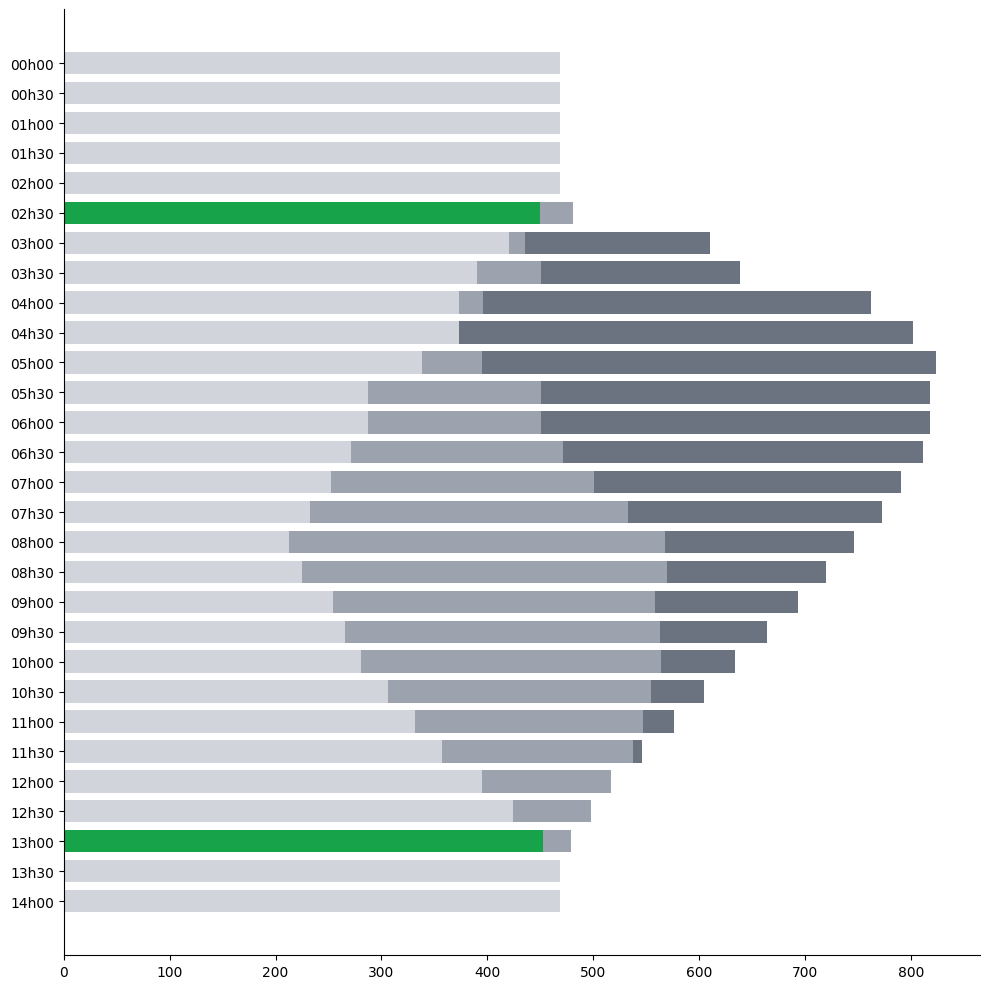

In [ ]:
import matplotlib.pyplot as plt

# df_scan doit contenir au minimum :
# ['heure_depart', 'temps_fluide', 'temps_ralenti', 'temps_bouche']

def _to_minutes(hhmm):
    h, m = hhmm.split('h')
    return int(h)*60 + int(m)

# 1) Tri chronologique (car '02h30' est une chaîne)
dfp = df_scan.copy()
dfp["start_min"] = dfp["heure_depart"].apply(_to_minutes)
dfp = dfp.sort_values("start_min", ascending=True)

# 2) Préparer les séries
fluide   = dfp["temps_fluide"].to_list()
ralenti  = dfp["temps_ralenti"].to_list()
bouche   = dfp["temps_bouche"].to_list()
labels   = dfp["heure_depart"].to_list()
y_pos    = range(len(labels))

# 3) Couleurs (vert pro + gris)
GREEN  = "#16A34A"  # vert pro (emerald-600)
G_F    = "#D1D5DB"  # gris clair (fluide non-sélection)
G_R    = "#9CA3AF"  # gris moyen (ralenti)
G_B    = "#6B7280"  # gris foncé (bouché)

# Indices des départs à mettre en vert (fluide uniquement)
special_set = {"02h30", "13h00"}
special_idx = [i for i, lab in enumerate(labels) if lab in special_set]

# 4) Construire les "left" pour l'empilement
left_f = [0]*len(labels)
left_r = fluide
left_b = [f+r for f, r in zip(fluide, ralenti)]

# 5) Tracé
fig, ax = plt.subplots(figsize=(10, 10))

# a) Fluide en gris partout...
ax.barh(y_pos, fluide, left=left_f, color=G_F, height=0.75)

# ...puis on RECOUVRE uniquement les barres "spéciales" en vert
for i in special_idx:
    ax.barh(i, fluide[i], left=0, color=GREEN, height=0.75)

# b) Ralenti & Bouché toujours en gris
ax.barh(y_pos, ralenti, left=left_r, color=G_R, height=0.75)
ax.barh(y_pos, bouche,  left=left_b, color=G_B, height=0.75)

# 6) Aesthetics minimalistes (LinkedIn-ready)
ax.set_yticks(list(y_pos))
ax.set_yticklabels(labels)
ax.invert_yaxis()  # départs les plus tôt en haut

# Pas de grille, pas de titres, pas de légende
ax.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Laisse les axes visibles (tu gèreras titrage en post-prod si besoin)
plt.tight_layout()
plt.show()